In [1]:
import mesa
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import time
import os

from Model_Ilya_Play_Area_Convolution import *

### Batch Simulations

#### Mesa batch run

In [2]:
params = {"num_type_a_1": (15), "num_type_a_2": (25), "is_torus": False, "grid_height": 25, "grid_width": 25, "immediate_killing": False, "aggressiveness": (0.025, 0.25), "avrg_viability_time_type_a": (35)}

results = mesa.batch_run(
    Microbiome,
    parameters = params,
    iterations = 10,
    max_steps = 2000,
    number_processes = 1,
    data_collection_period = 1,
    display_progress = True,
)

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [02:49<53:37, 169.33s/it]

In [ ]:
results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'num_type_a_1', 'num_type_a_2',
       'is_torus', 'grid_height', 'grid_width', 'immediate_killing',
       'aggressiveness', 'avrg_viability_time_type_a',
       'A1_Initial_Edge_Distance', 'A2_Initial_Edge_Distance',
       'A1_Initial_Aggressiveness', 'A2_Initial_Competition_Index',
       'A1_Number', 'A2_Number'],
      dtype='object')


In [14]:
batch_path = os.path.join(os.getcwd(), "Batch_runs_convolution")
file_path = os.path.join(batch_path, "Default_batch_3.csv")
results_df.to_csv(file_path)

#### Self written batch run function for predator prey model

In [2]:
def batch_run(num_type_a_1, num_type_a_2, is_torus, grid_dim, immediate_killing, aggressiveness, steps_number, iterations_per_condition):
    # inputs have have to be lists

    # Create all possible combinations of initial conditions
    initial_conditions = itertools.product(num_type_a_1, num_type_a_2, is_torus, grid_dim, immediate_killing, aggressiveness, steps_number, iterations_per_condition)
    
    output = {}
    counter = 0

    for i in initial_conditions:

        start_time = time.time()

        # Unpack each initial consition into separate varibales
        n_a1, n_a2, torus, grid, im_killing, aggr, steps_number, iteration = i

        # Start the simulation
        model = Microbiome(n_a1, n_a2, torus, grid, grid, immediate_killing = im_killing, aggressiveness = aggr)
        for s in range(steps_number):
            model.step()
        
        # Collect the data
        agent_num_data = model.datacollector.get_model_vars_dataframe()
        num_of_agents_1 = agent_num_data.loc[:,"A1_Number"]
        num_of_agents_2 = agent_num_data.loc[:,"A2_Number"]

        end_time = time.time()
        run_time = (end_time - start_time) / 60

        output[i] = [run_time, num_of_agents_1, num_of_agents_2]
        
        counter += 1
        print(f"Iteration {counter} done; run time: {run_time}.")

    # Output is a dictionary where each key is the combination of the intial conditions variables and the entry is a list containing runtime, number of predators and number of preys
    return output

In [ ]:
# Input for the batch run function
a1 = [20]
a2 = [20]
torus = [False]
grid = [25]
i_kill = [False]
aggress = [0.01]
max_steps = [2500]
iterations = 100

iterations_input = list(range(1,1+iterations))

# Calling the function
results = batch_run(a1, a2, torus, grid, i_kill, aggress, max_steps, iterations_input)

In [5]:
def create_batch_report(results_dictionary):

    iterations = list(results_dictionary.keys())
    steady_state = []
    prey_percentage = []
    predator_percentage = []

    batch_path = os.path.join(os.getcwd(), "Batch_runs_convolution", f"{iterations[-1]}")
    os.makedirs(batch_path)

    for i in iterations:
    
        run_data = results[i]
        run_time, n_predator, n_prey, time_steps = run_data[0], run_data[1], run_data[2], run_data[1].index

        plt.plot(time_steps, n_predator, label = "Predator")
        plt.plot(time_steps, n_prey, label = "Prey")

    # Adding labels and title
        plt.legend()
        plt.xlabel('Time Step')
        plt.ylabel('Number of Agents')
        plt.title(f"Initial conditions: {i}; run time: {np.round(run_time,2)} mins")

        plot_path = os.path.join(batch_path, f'{i}.jpg')
        plt.savefig(plot_path, format='jpg')

        # Displaying the plot
        plt.show()

        final_n_prey = n_prey.iloc[-1]
        final_n_predator = n_predator.iloc[-1]

        if final_n_predator > 0 and final_n_prey > 0:
            steady_state.append(True)

        else:
            steady_state.append(False)

        prey_percentage.append(np.round(final_n_prey/(final_n_predator+final_n_prey),2))
        predator_percentage.append(np.round(final_n_predator/(final_n_predator+final_n_prey),2))
    
    summary = {
        "Steady State" : steady_state,
        "Prey Percentage" : prey_percentage,
        "Predator Percentage" : predator_percentage
    }
    summary_df = pd.DataFrame(summary)
    file_path = os.path.join(batch_path, "perfomance_report.csv")
    summary_df.to_csv(file_path)

In [ ]:
# Calling the function to display the graphs and save csv report
create_batch_report(results)

### Trying new features of the model

#### Simulate both populations

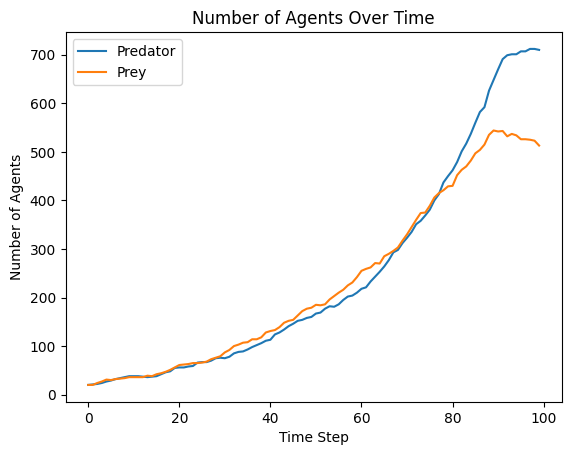

In [2]:
# Making x steps with in the model
x = 100

model = Microbiome(20, 20, 20, 20, 20, False, 25, 25, immediate_killing = False, aggressiveness = 0.01, avrg_viability_time_type_a = 50)
for i in range(x):
    model.step()

# Check the numbers of agents

agent_num_data = model.datacollector.get_model_vars_dataframe()
num_of_agents_1 = agent_num_data.loc[:,"A1_Number"]
num_of_agents_2 = agent_num_data.loc[:,"A2_Number"]
number_of_time_steps = agent_num_data.index

# Plotting the number of agents over time
plt.plot(number_of_time_steps, num_of_agents_1, label = "Predator")
plt.plot(number_of_time_steps, num_of_agents_2, label = "Prey")

# Adding labels and title
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Number of Agents')
plt.title('Number of Agents Over Time')

# Displaying the plot
plt.show()

In [4]:
model.output_initial_conditions()

(3.5, 4.0, 0.99, 0.59)

#### Simulate single population

In [ ]:
#Making x steps with in the model
x = 50

model = Microbiome(0,50, False, 10, 10, immediate_killing = False, aggressiveness = 0.01)
for i in range(x):
    model.step()

# Check the numbers of agents

agent_num_data = model.datacollector.get_model_vars_dataframe()
num_of_agents = agent_num_data.loc[:,"Type_a_2"]
number_of_time_steps = agent_num_data.index

# Plotting the number of agents over time
plt.plot(number_of_time_steps, num_of_agents)

# Adding labels and title
plt.xlabel('Time Step')
plt.ylabel('Number of Agents')
plt.title('Number of Agents Over Time')

# Displaying the plot
plt.show()

In [ ]:
s_mutens_radius = 0.75 # micrometers
average_bacteria_area = 4*math.pi*s_mutens_radius**2 
average_bacteria_area

In [ ]:
# Extract the data about mass of one of the bacteria
my_variable_view = []

my_agents = [agent for agent in model.schedule.agents if isinstance(agent, Type_a_1)]
for agent in my_agents:

    # Acess the variables of the current agent
    my_variable_view.append(agent.area)

    #print(f"{agent.unique_id}:{my_vars}")
    # Print the unique ID and variable of the current agent
    # if agent.energy_netto > 1:
    #     print(f"{agent.unique_id}:{agent.energy_netto}")

print(np.mean(my_variable_view),np.max(my_variable_view),np.min(my_variable_view),np.percentile(my_variable_view, 90)) 

# my_variable_view

In [ ]:
# Unpack the list of np array floats into a list of floats

float_list = []
for array in my_variable_view:
    if not isinstance(array, int):
        float_list.append(array[0])
    else:
        float_list.append(array)

my_variable_view = float_list 

In [ ]:
plt.hist(my_variable_view, bins=100, edgecolor='black')

# Adding labels and title
plt.xlabel('My Variable Values')
plt.ylabel('Frequency')
plt.title('Histogram')

# Displaying the histogram
plt.show()